In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
text = ''
X = vectorizer.fit_transform(text)



SyntaxError: invalid character in identifier (<ipython-input-20-37d4f666c4e5>, line 4)

In [4]:
# Generate predictors
X_raw = np.random.random(100*9)
X_raw = np.reshape(X_raw, (100, 9))

# Standardize the predictors
scaler = StandardScaler().fit(X_raw)
X = scaler.transform(X_raw)

# Add an intercept column to the model.
X = np.abs(np.concatenate((np.ones((X.shape[0],1)), X), axis=1))

# Define my "true" beta coefficients

beta = np.array([2,6,7,3,5,7,1,2,2,8])

# Y = Xb
Y_true = np.matmul(X,beta)

# Observed data with noise
Y = Y_true*np.exp(np.random.normal(loc=0.0, scale=0.2, size=100))

In [5]:
def mean_absolute_percentage_error(y_true, y_pred, sample_weights=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if np.any(y_true==0):
        print("Found zeroes in y_true. MAPE undefined. Removing from set...")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        if type(sample_weights) != type(None):
            sample_weights = np.array(sample_weights)
            sample_weights = np.delete(sample_weights, idx)
        
    if type(sample_weights) == type(None):
        return(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    else:
        sample_weights = np.array(sample_weights)
        assert len(sample_weights) == len(y_true)
        return(100/sum(sample_weights)*np.dot(
                sample_weights, (np.abs((y_true - y_pred) / y_true))
        ))
    
loss_function = mean_absolute_percentage_error

In [6]:
from scipy.optimize import minimize

def objective_function(beta, X, Y):
    error = loss_function(np.matmul(X,beta), Y)
    return(error)

# You must provide a starting point at which to initialize
# the parameter search space
beta_init = np.array([1]*X.shape[1])
result = minimize(objective_function, beta_init, args=(X,Y),
                  method='BFGS', options={'maxiter': 500})

# The optimal values for the input parameters are stored
# in result.x
beta_hat = result.x
print(beta_hat)

[ 5.26369843  5.08958273  8.49793391  1.82781447  2.7843254   6.40457697
 -0.68349731  0.63699135  2.31620298  9.92712145]


In [7]:
loss_function(np.matmul(X,beta_hat), Y)

12.881933363538634

In [8]:
class CustomLinearModel:
    """
    Linear model: Y = XB, fit by minimizing the provided loss_function
    with L2 regularization
    """
    def __init__(self, loss_function=mean_absolute_percentage_error, 
                 X=None, Y=None, sample_weights=None, beta_init=None, 
                 regularization=0.00012):
        self.regularization = regularization
        self.beta = None
        self.loss_function = loss_function
        self.sample_weights = sample_weights
        self.beta_init = beta_init
        
        self.X = X
        self.Y = Y
            
    
    def predict(self, X):
        prediction = np.matmul(X, self.beta)
        return(prediction)

    def model_error(self):
        error = self.loss_function(
            self.predict(self.X), self.Y, sample_weights=self.sample_weights
        )
        return(error)
    
    def l2_regularized_loss(self, beta):
        self.beta = beta
        return(self.model_error() + \
               sum(self.regularization*np.array(self.beta)**2))
    
    def fit(self, maxiter=250):        
        # Initialize beta estimates (you may need to normalize
        # your data and choose smarter initialization values
        # depending on the shape of your loss function)
        if type(self.beta_init)==type(None):
            # set beta_init = 1 for every feature
            self.beta_init = np.array([1]*self.X.shape[1])
        else: 
            # Use provided initial values
            pass
            
        if self.beta!=None and all(self.beta_init == self.beta):
            print("Model already fit once; continuing fit with more itrations.")
            
        res = minimize(self.l2_regularized_loss, self.beta_init,
                       method='BFGS', options={'maxiter': 500})
        self.beta = res.x
        self.beta_init = self.beta

l2_mape_model = CustomLinearModel(
    loss_function=mean_absolute_percentage_error,
    X=X, Y=Y, regularization=0.00012
)
l2_mape_model.fit()
l2_mape_model.beta

array([ 4.71511879,  5.31496938,  8.68726636,  1.93584099,  2.71881164,
        6.43907179, -0.59309471,  0.75186615,  2.26318172,  9.90273579])

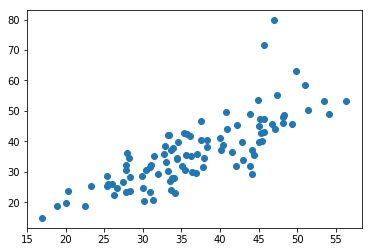

In [10]:
plt.scatter(l2_mape_model.predict(X), Y)

In [9]:
from sklearn.model_selection import KFold

# Used to cross-validate models and identify optimal lambda
class CustomCrossValidator:
    
    """
    Cross validates arbitrary model using MAPE criterion on
    list of lambdas.
    """
    def __init__(self, X, Y, ModelClass,
                 sample_weights=None,
                 loss_function=mean_absolute_percentage_error):
        
        self.X = X
        self.Y = Y
        self.ModelClass = ModelClass
        self.loss_function = loss_function
        self.sample_weights = sample_weights
    
    def cross_validate(self, lambdas, num_folds=10):
        """
        lambdas: set of regularization parameters to try
        num_folds: number of folds to cross-validate against
        """
        
        self.lambdas = lambdas
        self.cv_scores = []
        X = self.X
        Y = self.Y 
        
        # Beta values are not likely to differ dramatically
        # between differnt folds. Keeping track of the estimated
        # beta coefficients and passing them as starting values
        # to the .fit() operator on our model class can significantly
        # lower the time it takes for the minimize() function to run
        beta_init = None
        
        for lam in self.lambdas:
            print("Lambda: {}".format(lam))
            
            # Split data into training/holdout sets
            kf = KFold(n_splits=num_folds, shuffle=True)
            kf.get_n_splits(X)
            
            # Keep track of the error for each holdout fold
            k_fold_scores = []
            
            # Iterate over folds, using k-1 folds for training
            # and the k-th fold for validation
            f = 1
            for train_index, test_index in kf.split(X):
                # Training data
                CV_X = X[train_index,:]
                CV_Y = Y[train_index]
                CV_weights = None
                if type(self.sample_weights) != type(None):
                    CV_weights = self.sample_weights[train_index]
                
                # Holdout data
                holdout_X = X[test_index,:]
                holdout_Y = Y[test_index]
                holdout_weights = None
                if type(self.sample_weights) != type(None):
                    holdout_weights = self.sample_weights[test_index]
                
                # Fit model to training sample
                lambda_fold_model = self.ModelClass(
                    regularization=lam,
                    X=CV_X,
                    Y=CV_Y,
                    sample_weights=CV_weights,
                    beta_init=beta_init,
                    loss_function=self.loss_function
                )
                lambda_fold_model.fit()
                
                # Extract beta values to pass as beta_init 
                # to speed up estimation of the next fold
                beta_init = lambda_fold_model.beta
                
                # Calculate holdout error
                fold_preds = lambda_fold_model.predict(holdout_X)
                fold_mape = mean_absolute_percentage_error(
                    holdout_Y, fold_preds, sample_weights=holdout_weights
                )
                k_fold_scores.append(fold_mape)
                print("Fold: {}. Error: {}".format( f, fold_mape))
                f += 1
            
            # Error associated with each lambda is the average
            # of the errors across the k folds
            lambda_scores = np.mean(k_fold_scores)
            print("LAMBDA AVERAGE: {}".format(lambda_scores))
            self.cv_scores.append(lambda_scores)
        
        # Optimal lambda is that which minimizes the cross-validation error
        self.lambda_star_index = np.argmin(self.cv_scores)
        self.lambda_star = self.lambdas[self.lambda_star_index]
        print("\n\n**OPTIMAL LAMBDA: {}**".format(self.lambda_star))

In [11]:
# User must specify lambdas over which to search
lambdas = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

cross_validator = CustomCrossValidator(
    X, Y, CustomLinearModel,
    loss_function=mean_absolute_percentage_error
)
cross_validator.cross_validate(lambdas, num_folds=5)

Lambda: 1
Fold: 1. Error: 27.611043437826126
Fold: 2. Error: 34.70856972567844
Fold: 3. Error: 32.23682865171843
Fold: 4. Error: 32.93096144537122
Fold: 5. Error: 35.524295395923225
LAMBDA AVERAGE: 32.60233973130349
Lambda: 0.1
Fold: 1. Error: 14.485593262785212
Fold: 2. Error: 16.929303669184982
Fold: 3. Error: 16.963351251097038
Fold: 4. Error: 16.832598010696646
Fold: 5. Error: 14.494949859697293
LAMBDA AVERAGE: 15.941159210692234
Lambda: 0.01
Fold: 1. Error: 13.29104128000923
Fold: 2. Error: 13.368084371129015
Fold: 3. Error: 20.38849277576705
Fold: 4. Error: 17.57683924661707
Fold: 5. Error: 17.269230288186993
LAMBDA AVERAGE: 16.37873759234187
Lambda: 0.001
Fold: 1. Error: 14.797762161282174
Fold: 2. Error: 15.945272054963642
Fold: 3. Error: 14.725059000702798
Fold: 4. Error: 15.469369660824734
Fold: 5. Error: 15.732011042206715
LAMBDA AVERAGE: 15.333894783996012
Lambda: 0.0001
Fold: 1. Error: 14.670276685185904
Fold: 2. Error: 16.257686506790712
Fold: 3. Error: 16.45746117270353
